<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc" style="margin-top: 1em;"><ul class="toc-item"><li><span><a href="#MNIST-Dataset" data-toc-modified-id="MNIST-Dataset-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>MNIST Dataset</a></span><ul class="toc-item"><li><span><a href="#Get-the-MNIST-data" data-toc-modified-id="Get-the-MNIST-data-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Get the MNIST data</a></span></li><li><span><a href="#MLP-in-TensorFlow" data-toc-modified-id="MLP-in-TensorFlow-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>MLP in TensorFlow</a></span></li><li><span><a href="#MLP-in-Keras" data-toc-modified-id="MLP-in-Keras-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>MLP in Keras</a></span></li><li><span><a href="#MLP-in-TFLearn" data-toc-modified-id="MLP-in-TFLearn-1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>MLP in TFLearn</a></span></li></ul></li><li><span><a href="#TimeSeries-Data---MLP---Keras" data-toc-modified-id="TimeSeries-Data---MLP---Keras-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>TimeSeries Data - MLP - Keras</a></span><ul class="toc-item"><li><span><a href="#Prepare-the-data" data-toc-modified-id="Prepare-the-data-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Prepare the data</a></span></li><li><span><a href="#Build,-Train-and-Evaluate-the-Model" data-toc-modified-id="Build,-Train-and-Evaluate-the-Model-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Build, Train and Evaluate the Model</a></span></li></ul></li></ul></div>

# MultiLayer Perceptron <a class="tocSkip">

In [2]:
import numpy as np
np.random.seed(123)
print("NumPy:{}".format(np.__version__))

import pandas as pd
print("Pandas:{}".format(pd.__version__))

import math
import os

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 10
print("Matplotlib:{}".format(mpl.__version__))

import tensorflow as tf
tf.set_random_seed(123)
print("TensorFlow:{}".format(tf.__version__))

import keras
print("Keras:{}".format(keras.__version__))

NumPy:1.14.5
Pandas:0.22.0
Matplotlib:2.2.2
TensorFlow:1.11.0
Keras:2.2.4


Using TensorFlow backend.


In [3]:
DATASETSLIB_HOME = '../datasetslib'
import sys
if not DATASETSLIB_HOME in sys.path:
    sys.path.append(DATASETSLIB_HOME)
%reload_ext autoreload
%autoreload 2
import datasetslib

from datasetslib import util as dsu

In [4]:
datasetslib.datasets_root = os.path.join(os.path.expanduser('~'),'datasets')

# MNIST Dataset

## Get the MNIST data

In [5]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets(os.path.join(datasetslib.datasets_root, 'mnist'),
                                  one_hot=True)

X_train = mnist.train.images
X_test = mnist.test.images
Y_train = mnist.train.labels
Y_test = mnist.test.labels

num_outputs = 10  # 0-9 digits
num_inputs = 784  # total pixels

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting /home/ubuntu/datasets/mnist/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting /home/ubuntu/datasets/mnist/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting /home/ubuntu/datasets/mnist/t10k-images-idx3-ubyte.gz
Extracting /home/ubuntu/datasets/mnist/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


## MLP in TensorFlow

In [6]:
tf.reset_default_graph()

In [7]:
def mlp(x, num_inputs, num_outputs, num_layers, num_neurons):
    w = []
    b = []
    for i in range(num_layers):
        # weights
        w.append(tf.Variable(tf.random_normal(
            [num_inputs if i == 0 else num_neurons[i - 1],
             num_neurons[i]]),
            name="w_{0:04d}".format(i)
        ))
        # biases
        b.append(tf.Variable(tf.random_normal(
            [num_neurons[i]]),
            name="b_{0:04d}".format(i)
        ))
    w.append(tf.Variable(tf.random_normal(
        [num_neurons[num_layers - 1] if num_layers > 0 else num_inputs,
         num_outputs]), name="w_out"))
    b.append(tf.Variable(tf.random_normal([num_outputs]), name="b_out"))

    # x is input layer
    layer = x
    # add hidden layers
    for i in range(num_layers):
        layer = tf.nn.relu(tf.matmul(layer, w[i]) + b[i])
    # add output layer
    layer = tf.matmul(layer, w[num_layers]) + b[num_layers]

    return layer


def mnist_batch_func(batch_size=100):
    X_batch, Y_batch = mnist.train.next_batch(batch_size)
    return [X_batch, Y_batch]


def tensorflow_classification(n_epochs, n_batches,
                              batch_size, batch_func,
                              model, optimizer, loss, accuracy_function,
                              X_test, Y_test):
    with tf.Session() as tfs:
        tfs.run(tf.global_variables_initializer())
        for epoch in range(n_epochs):
            epoch_loss = 0.0
            for batch in range(n_batches):
                X_batch, Y_batch = batch_func(batch_size)
                feed_dict = {x: X_batch, y: Y_batch}
                _, batch_loss = tfs.run([optimizer, loss], feed_dict)
                epoch_loss += batch_loss
            average_loss = epoch_loss / n_batches
            print("epoch: {0:04d}   loss = {1:0.6f}".format(
                epoch, average_loss))
        feed_dict = {x: X_test, y: Y_test}
        accuracy_score = tfs.run(accuracy_function, feed_dict=feed_dict)
        print("accuracy={0:.8f}".format(accuracy_score))

In [8]:
tf.reset_default_graph()

In [9]:
num_layers = 0
num_neurons = []
learning_rate = 0.01
n_epochs = 50
batch_size = 100
n_batches = int(mnist.train.num_examples / batch_size)

# input images
x = tf.placeholder(dtype=tf.float32, name="x", shape=[None, num_inputs])
# target output
y = tf.placeholder(dtype=tf.float32, name="y", shape=[None, num_outputs])

model = mlp(x=x,
            num_inputs=num_inputs,
            num_outputs=num_outputs,
            num_layers=num_layers,
            num_neurons=num_neurons)

# loss function
loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(logits=model, labels=y))
# optimizer function
optimizer = tf.train.GradientDescentOptimizer(
    learning_rate=learning_rate).minimize(loss)

predictions_check = tf.equal(tf.argmax(model, 1), tf.argmax(y, 1))
accuracy_function = tf.reduce_mean(tf.cast(predictions_check, tf.float32))

tensorflow_classification(n_epochs=n_epochs,
                          n_batches=n_batches,
                          batch_size=batch_size,
                          batch_func=mnist_batch_func,
                          model=model,
                          optimizer=optimizer,
                          loss=loss,
                          accuracy_function=accuracy_function,
                          X_test=mnist.test.images,
                          Y_test=mnist.test.labels
                          )

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.

epoch: 0000   loss = 11.048409
epoch: 0001   loss = 5.183520
epoch: 0002   loss = 3.439295
epoch: 0003   loss = 2.640733
epoch: 0004   loss = 2.193117
epoch: 0005   loss = 1.906528
epoch: 0006   loss = 1.706867
epoch: 0007   loss = 1.560023
epoch: 0008   loss = 1.446863
epoch: 0009   loss = 1.357087
epoch: 0010   loss = 1.284131
epoch: 0011   loss = 1.223282
epoch: 0012   loss = 1.171786
epoch: 0013   loss = 1.127435
epoch: 0014   loss = 1.088694
epoch: 0015   loss = 1.054394
epoch: 0016   loss = 1.024117
epoch: 0017   loss = 0.996739
epoch: 0018   loss = 0.972155
epoch: 0019   loss = 0.949581
epoch: 0020   loss = 0.929112
epoch: 0021   loss = 0.910026
epoch: 0022   loss = 0.892642
epoch: 0023   loss = 0.876412
epoch: 0024   loss = 0.861330
epoch: 0025   loss = 0.847167
epoch: 0026   loss = 0.83412

In [10]:
tf.reset_default_graph()

In [11]:
num_layers = 1 
num_neurons = []
for i in range(num_layers):
    num_neurons.append(8)
    
learning_rate = 0.01
n_epochs = 50
batch_size = 100
n_batches = int(mnist.train.num_examples/batch_size)

# input images
x = tf.placeholder(dtype=tf.float32, name="x", shape=[None, num_inputs]) 
# target output
y = tf.placeholder(dtype=tf.float32, name="y", shape=[None, num_outputs]) 

model = mlp(x=x, 
            num_inputs=num_inputs, 
            num_outputs=num_outputs, 
            num_layers=num_layers, 
            num_neurons=num_neurons)

# loss function
#loss = tf.reduce_mean(-tf.reduce_sum(y * tf.log(model), axis=1))
loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=model, labels=y))
# optimizer function
optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate).minimize(loss)
predictions_check = tf.equal(tf.argmax(model,1), tf.argmax(y,1))
accuracy_function = tf.reduce_mean(tf.cast(predictions_check, tf.float32))

tensorflow_classification(n_epochs=n_epochs, 
                          n_batches=n_batches, 
                          batch_size=batch_size, 
                          batch_func=mnist_batch_func, 
                          model = model, 
                          optimizer = optimizer, 
                          loss = loss, 
                          accuracy_function = accuracy_function, 
                          X_test = mnist.test.images, 
                          Y_test = mnist.test.labels
                         )

epoch: 0000   loss = 4.013396
epoch: 0001   loss = 2.302745
epoch: 0002   loss = 2.156557
epoch: 0003   loss = 2.079378
epoch: 0004   loss = 2.026683
epoch: 0005   loss = 1.987903
epoch: 0006   loss = 1.958130
epoch: 0007   loss = 1.932892
epoch: 0008   loss = 1.909715
epoch: 0009   loss = 1.887257
epoch: 0010   loss = 1.865864
epoch: 0011   loss = 1.844288
epoch: 0012   loss = 1.823081
epoch: 0013   loss = 1.801307
epoch: 0014   loss = 1.778486
epoch: 0015   loss = 1.754043
epoch: 0016   loss = 1.726848
epoch: 0017   loss = 1.695823
epoch: 0018   loss = 1.662781
epoch: 0019   loss = 1.630441
epoch: 0020   loss = 1.598397
epoch: 0021   loss = 1.568061
epoch: 0022   loss = 1.537702
epoch: 0023   loss = 1.508838
epoch: 0024   loss = 1.480578
epoch: 0025   loss = 1.452838
epoch: 0026   loss = 1.426458
epoch: 0027   loss = 1.400067
epoch: 0028   loss = 1.375169
epoch: 0029   loss = 1.351013
epoch: 0030   loss = 1.326956
epoch: 0031   loss = 1.303237
epoch: 0032   loss = 1.281651
epoch: 003

In [12]:
tf.reset_default_graph()

In [13]:
num_layers = 2
num_neurons = []
for i in range(num_layers):
    num_neurons.append(256)
    
learning_rate = 0.01
n_epochs = 50
batch_size = 100
n_batches = int(mnist.train.num_examples/batch_size)

# input images
x = tf.placeholder(dtype=tf.float32, name="x", shape=[None, num_inputs]) 
# target output
y = tf.placeholder(dtype=tf.float32, name="y", shape=[None, num_outputs]) 

model = mlp(x=x, 
            num_inputs=num_inputs, 
            num_outputs=num_outputs, 
            num_layers=num_layers, 
            num_neurons=num_neurons)

# loss function
#loss = tf.reduce_mean(-tf.reduce_sum(y * tf.log(model), axis=1))
loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=model, 
                                                              labels=y))
# optimizer function
optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate).minimize(loss)

predictions_check = tf.equal(tf.argmax(model,1), tf.argmax(y,1))
accuracy_function = tf.reduce_mean(tf.cast(predictions_check, tf.float32))

tensorflow_classification(n_epochs=n_epochs, 
                          n_batches=n_batches, 
                          batch_size=batch_size, 
                          batch_func=mnist_batch_func, 
                          model = model, 
                          optimizer = optimizer, 
                          loss = loss, 
                          accuracy_function = accuracy_function, 
                          X_test = mnist.test.images, 
                          Y_test = mnist.test.labels
                         )

epoch: 0000   loss = 60.361289
epoch: 0001   loss = 13.019150
epoch: 0002   loss = 8.053316
epoch: 0003   loss = 5.666510
epoch: 0004   loss = 4.276411
epoch: 0005   loss = 3.376717
epoch: 0006   loss = 2.715352
epoch: 0007   loss = 2.202647
epoch: 0008   loss = 1.851583
epoch: 0009   loss = 1.539788
epoch: 0010   loss = 1.315987
epoch: 0011   loss = 1.089433
epoch: 0012   loss = 0.937370
epoch: 0013   loss = 0.807009
epoch: 0014   loss = 0.703406
epoch: 0015   loss = 0.614633
epoch: 0016   loss = 0.519920
epoch: 0017   loss = 0.460075
epoch: 0018   loss = 0.402827
epoch: 0019   loss = 0.347191
epoch: 0020   loss = 0.291785
epoch: 0021   loss = 0.259045
epoch: 0022   loss = 0.223607
epoch: 0023   loss = 0.195840
epoch: 0024   loss = 0.165532
epoch: 0025   loss = 0.147145
epoch: 0026   loss = 0.121334
epoch: 0027   loss = 0.107570
epoch: 0028   loss = 0.095601
epoch: 0029   loss = 0.080596
epoch: 0030   loss = 0.067154
epoch: 0031   loss = 0.059556
epoch: 0032   loss = 0.045005
epoch: 0

## MLP in Keras


In [14]:
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import SGD

In [15]:
tf.reset_default_graph()
keras.backend.clear_session()

In [16]:
num_layers = 2
num_neurons = []
for i in range(num_layers):
    num_neurons.append(256)
    
learning_rate = 0.01
n_epochs = 50
batch_size = 100

model = Sequential()
model.add(Dense(units=num_neurons[0], activation='relu', 
                input_shape=(num_inputs,)))
model.add(Dense(units=num_neurons[1], activation='relu'))
model.add(Dense(units=num_outputs, activation='softmax'))
model.summary()

model.compile(loss='categorical_crossentropy',
              optimizer=SGD(lr=learning_rate),
              metrics=['accuracy'])

model.fit(X_train, Y_train,
                    batch_size=batch_size,
                    epochs=n_epochs)

score = model.evaluate(X_test, Y_test)
print('\nTest loss:', score[0])
print('Test accuracy:', score[1])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 256)               200960    
_________________________________________________________________
dense_2 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_3 (Dense)              (None, 10)                2570      
Total params: 269,322
Trainable params: 269,322
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
55000/55000 [==============================] - 2s 33us/step - loss: 1.0688 - acc: 0.7467
Epoch 2/50
55000/55000 [==============================] - 2s 29us/step - loss: 0.4358 - acc: 0.8813
Epoch 3/50
55000/55000 [==============================] - 2s 29us/step - loss: 0.3535 - acc: 0.9003
Epoch 4/50
55000/55000 [==============================] - 2s 29us/step - loss: 0.3147 - acc: 0.9103


## MLP in TFLearn

In [17]:
import tflearn

In [18]:
tf.reset_default_graph()

In [19]:
num_layers = 2
num_neurons = []
for i in range(num_layers):
    num_neurons.append(256)
    
learning_rate = 0.01
n_epochs = 50
batch_size = 100

# Build deep neural network
input_layer = tflearn.input_data(shape=[None, num_inputs])
dense1 = tflearn.fully_connected(input_layer, num_neurons[0], activation='relu')
dense2 = tflearn.fully_connected(dense1, num_neurons[1], activation='relu')
softmax = tflearn.fully_connected(dense2, num_outputs, activation='softmax')

optimizer = tflearn.SGD(learning_rate=learning_rate)
net = tflearn.regression(softmax, optimizer=optimizer, 
                         metric=tflearn.metrics.Accuracy(), 
                         loss='categorical_crossentropy')
model = tflearn.DNN(net)

model.fit(X_train, Y_train, 
          n_epoch=n_epochs, batch_size=batch_size, 
          show_metric=True, run_id='dense_model')

score = model.evaluate(X_test, Y_test)
print('Test accuracy:', score[0])

Training Step: 27499  | total loss: 0.10560 | time: 2.677s
| SGD | epoch: 050 | loss: 0.10560 - acc: 0.9730 -- iter: 54900/55000
Training Step: 27500  | total loss: 0.10170 | time: 2.682s
| SGD | epoch: 050 | loss: 0.10170 - acc: 0.9737 -- iter: 55000/55000
--
Test accuracy: 0.966


# TimeSeries Data - MLP - Keras

## Prepare the data

In [22]:
datasetslib.datasets_root

'/home/ubuntu/datasets'

In [23]:
import os

#dataframe = pd.read_csv(os.path.join(datasetslib.datasets_root, 
#                                     'ts-data', 
#                                     '../data/international-airline-passengers.csv'), 
#                        usecols=[1],header=0)

dataframe = pd.read_csv('../data/international-airline-passengers.csv', 
                        usecols=[1],header=0)
dataset = dataframe.values
dataset = dataset.astype('float32')

In [24]:
# normalize the dataset
#scaler = skpp.MinMaxScaler(feature_range=(0, 1))
#normalized_dataset = scaler.fit_transform(dataset)

In [25]:
# split into train and test sets
train,test=dsu.train_test_split(dataset,train_size=0.67)
print(len(train), len(test))

97 48


In [26]:
# reshape into X=t-1,t and Y=t+1
n_x=2
n_y=1

X_train, Y_train, X_test, Y_test = dsu.mvts_to_xy(train,test,n_x=n_x,n_y=n_y)

## Build, Train and Evaluate the Model

In [27]:
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import SGD

In [30]:
tf.reset_default_graph()
keras.backend.clear_session()

In [34]:
print(X_train.shape, Y_train.shape)

(95, 2) (95, 1)


In [35]:
num_layers = 2
num_neurons = [8,8]
n_epochs = 50
batch_size = 2


In [36]:
model = Sequential()
model.add(Dense(num_neurons[0], activation='relu', input_shape=(n_x,)))
model.add(Dense(num_neurons[1], activation='relu'))
model.add(Dense(units=1))
model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 8)                 24        
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 72        
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 9         
Total params: 105
Trainable params: 105
Non-trainable params: 0
_________________________________________________________________


In [37]:
model.compile(loss='mse', optimizer='adam')


In [38]:
model.fit(X_train, Y_train,
                    batch_size=batch_size,
                    epochs=n_epochs)



Epoch 1/50
95/95 [==============================] - 0s 3ms/step - loss: 4577.3356
Epoch 2/50
95/95 [==============================] - 0s 1ms/step - loss: 1058.4142
Epoch 3/50
95/95 [==============================] - 0s 1ms/step - loss: 875.4335
Epoch 4/50
95/95 [==============================] - 0s 1ms/step - loss: 881.2437
Epoch 5/50
95/95 [==============================] - 0s 1ms/step - loss: 874.9052
Epoch 6/50
95/95 [==============================] - 0s 1ms/step - loss: 903.3823
Epoch 7/50
95/95 [==============================] - 0s 1ms/step - loss: 883.6966
Epoch 8/50
95/95 [==============================] - 0s 1ms/step - loss: 873.8367
Epoch 9/50
95/95 [==============================] - 0s 1ms/step - loss: 879.8582
Epoch 10/50
95/95 [==============================] - 0s 1ms/step - loss: 901.9072
Epoch 11/50
95/95 [==============================] - 0s 1ms/step - loss: 869.9791
Epoch 12/50
95/95 [==============================] - 0s 1ms/step - loss: 866.9299
Epoch 13/50
95/95 [====

In [39]:
print(X_test.shape, Y_test.shape)

(46, 2) (46, 1)


In [47]:
# make predictions
Y_train_pred = model.predict(X_train)
Y_test_pred = model.predict(X_test)


In [48]:
# shift train predictions for plotting
Y_train_pred_plot = np.empty_like(dataset)
Y_train_pred_plot[:, :] = np.nan
Y_train_pred_plot[n_x-1:len(Y_train_pred)+n_x-1, :] = Y_train_pred


In [49]:
# shift test predictions for plotting
Y_test_pred_plot = np.empty_like(dataset)
Y_test_pred_plot[:, :] = np.nan
Y_test_pred_plot[len(Y_train_pred)+(n_x*2)-1:len(dataset)-1, :] = Y_test_pred


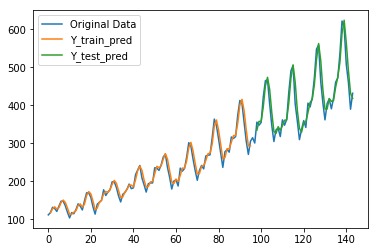

In [50]:
# plot baseline and predictions
plt.plot(dataset,label='Original Data')
plt.plot(Y_train_pred_plot,label='Y_train_pred')
plt.plot(Y_test_pred_plot,label='Y_test_pred')
plt.legend()
plt.show()